In [121]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [42]:
points = [(0,0),(0,0.25),(0.1,0.8),(0.2,0.9),(0.3,0.93),(0.45,0.00),(0.55,0.1),(0.7,-0.75),(0.8,-0.3),(0.9,-0.5),(1,0.2)]

In [43]:
xs = [x[0] for x in points]
ys = [y[1] for y in points]

# Our data. We will perform Bayesian curve fitting on it.

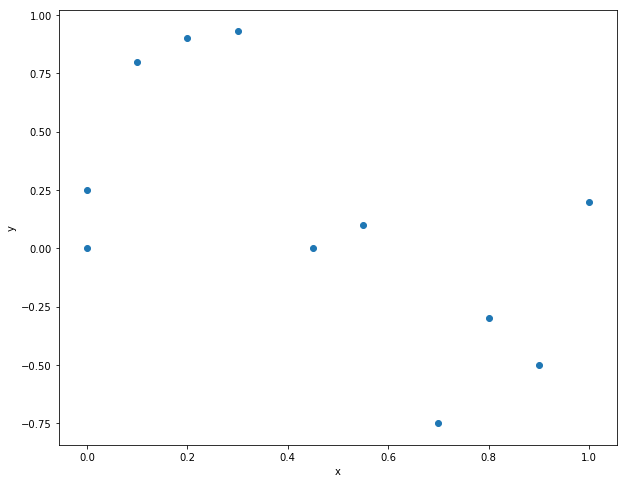

In [83]:
f = plt.figure(figsize=(10,8))
ax = f.add_subplot(111)
ax.scatter(xs,ys)

ax.set_xlabel('x')
ax.set_ylabel('y')

plt.show()

In [111]:
alpha = 5*10**(-3)
beta = 11.1
M = 9

This is a demonstration on how to obtain the quantity $p(t|x,\mathbf{x},\mathbf{t})$, which will give us uncertainty about the new target $t$, **given**: the input that generated it $x$ and all the inputs along with corresponding targets: $\mathbf{x},\mathbf{t}$ respecitvely.

The equation is this:

$$p(t|x,\mathbf{x},\mathbf{t}) = \int  p(t|x,\mathbf{w}) p(\mathbf{w}|\mathbf{x},\mathbf{t}) d\mathbf{w}$$

for the derivation of the above go to my blog post on: smallmargin.uk

This equation has an analytic solution:
$$p(t|x,\mathbf{x},\mathbf{t}) = \mathcal{N}(t|m(x),s^2(x))$$

where:
$$m(x) = \beta \phi(x)^T \mathbf{S} \sum_{n=1}^N \phi(x_n) t_n$$
$$s^2(x) = \beta^{-1} + \phi(x)^T \mathbf{S} \phi(x)$$
matrix $\mathbf{S}$ is given by:
$$\mathbf{S}^{-1} = \alpha \mathbf{I} + \beta \sum_{n=1}^N \phi(x_n) \phi(x_n)^T$$
and $\phi(x)$ is defined such as: $\phi_i (x) = x^i$ for $i=0,...,M$

Method implemented below, correspond to these quantities/constructs.

Also note that $m(x) \in \mathbb{R}$, $s^2(x) \in \mathbb{R}$ and $\mathbf{S} \in \mathbb{R}^{(M+1)\times (M+1)}$

In [229]:
def variance(alpha, beta, new_x, x_vec, D):
    S = matrix_S(alpha,beta,new_x,x_vec, D)
    return (1/beta)+(phi(new_x, D).T @ S @ phi(new_x, D))

In [223]:
def phi(x, D):
    """
    x - is the real valued constant.
    D - is an integer dimension. 
    """
    assert isinstance(D, int), "Dimension D, should be an integer."
    
    dimension = D+1 # We are including a constant here.
    returnVector = [0]*dimension
    for i in range(dimension): returnVector[i] += x**(i)
    
    returnVector = np.array(returnVector)
    returnVector = returnVector.reshape(returnVector.shape + (1,))
    
    return returnVector

In [230]:
def mean(alpha, beta, new_x, target_vec, x_vec, D):
    
    sum_vec_x = 0
    for i in range(len(x_vec)): sum_vec_x += phi(x_vec[i], D)*target_vec[i]
    
    S = matrix_S(alpha,beta,new_x,x_vec, D)
    
    return beta*((phi(new_x, D).T @ S) @ sum_vec_x)

In [306]:
def matrix_S(alpha, beta, new_x, x_vec, D):
    first_expr  = alpha*np.eye(D+1)
    second_expr = 0
    for i in range(len(x_vec)): second_expr += phi(x_vec[i], D).dot(phi(x_vec[i],D).T)
    return np.linalg.inv(first_expr+beta*second_expr)

To multiply column vecotr by row vector:
$$\phi(x_n) \phi(x)^T$$
we can write: np.outer(phi(2,2),phi(2,2)), which will return a $3 \times 3$ matrix (because we take into account the cosntant in $\mathbf{w}$ as well.

In [224]:
a = phi(2,2)

In [228]:
a.dot(a.T)

array([[ 1,  2,  4],
       [ 2,  4,  8],
       [ 4,  8, 16]])

Identity matrix can be created with np.eye(n)

In [82]:
2*np.eye(3)

array([[ 2.,  0.,  0.],
       [ 0.,  2.,  0.],
       [ 0.,  0.,  2.]])

To multiply row vector, $a = [1,2,3]$ by matrix $I = [[1,0,0],[0,1,0],[0,0,1]]$:

In [92]:
a = np.array([1,2,3])
I = np.eye(len(a))

np.dot(a,I)

array([ 1.,  2.,  3.])

# Actual procedural updating of the distribution of new target $t$

With start with just one given point: (0,0), which constitutes our vector x: $\mathbf{x}$. The new point then arrives, which is $(0,0.25)$. And we compute the $p(t|x,\mathbf{x},\mathbf{t})$ for this new point.

In [564]:
x_vec = np.linspace(-6,0,300)
t_vec = [np.sin(x+np.random.uniform(-0.3,0.3)) for x in x_vec] 

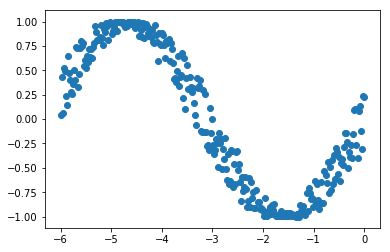

In [565]:
plt.scatter(x_vec,t_vec)
plt.show()

In [566]:
x_predict = np.linspace(0,5,100)
y_predict = [np.sin(x+np.random.uniform(-0.2,0.2)) for x in x_predict]

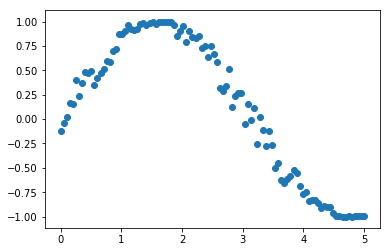

In [567]:
plt.scatter(x_predict,y_predict)
plt.show()

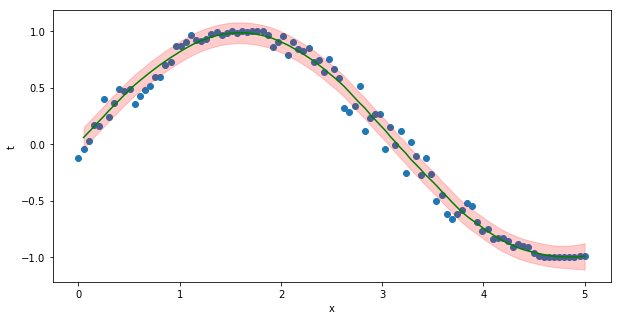

In [570]:
means     = [0.] * (len(x_predict) - 1)  # Important, have 0., otherwise will be an array of integers.
variances = [0.] * (len(x_predict) - 1)

for i in range(len(x_predict) - 1):
    x_vec = np.append(x_vec,x_predict[i]) # x_vec
    t_vec = np.append(t_vec,y_predict[i]) # target_vec
    new_datapoint = x_predict[i + 1]
    new_x = new_datapoint
    p_t_mean = mean(alpha, beta, new_x, t_vec, x_vec, M)
    p_t_var = variance(alpha, beta, new_x, x_vec, M)
    means[i] = p_t_mean[0][0]
    variances[i] = (p_t_var[0][0] + means[i], means[i] - p_t_var[0][0])

f = plt.figure(figsize=(10,5))
ax = f.add_subplot(111)

ax.scatter(x_predict,y_predict)
ax.plot(x_predict[1:],means,c='green')
miny = [y[1] for y in variances]
maxy = [y[0] for y in variances]
ax.fill_between(x_predict[1:],miny,maxy,alpha=0.2,color='red')

ax.set_xlabel('x')
ax.set_ylabel('t')
plt.show()

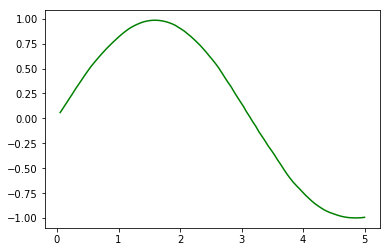

In [571]:
plt.plot(x_predict[1:],means,c='green')